In [1]:
# imports
import numpy as np
import pandas as pd
import os
import PIL
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ["SM_FRAMEWORK"] = "tf.keras"

In [ ]:
#pip install --upgrade tensorflow

In [ ]:
#!pip uninstall tensorflow -y
#pip uninstall keras
# Try to switch the version of tensorflow and kera
#pip install tf-nightly
#pip install keras==2.6.0
#!pip install  tensorflow==2.6
#tf.config.set_visible_devices([], 'GPU')

In [2]:
# CoAtNet
class MBConv(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides = 1, expand_ratio = 1, se_ratio = 4, residual = True, momentum = 0.9, epsilon = 0.01, convolution = tf.keras.layers.Conv2D, activation = tf.nn.swish, kernel_initializer = "he_normal", **kwargs):
        super(MBConv, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.expand_ratio = expand_ratio
        self.se_ratio = se_ratio
        self.residual = residual
        self.momentum = momentum
        self.epsilon = epsilon
        self.convolution = convolution
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        
    def build(self, input_shape):
        self.layers = []
        self.post = []
        if self.expand_ratio != 1:
            conv = self.convolution(input_shape[-1] * self.expand_ratio, 1, use_bias = False, kernel_initializer = self.kernel_initializer)
            norm = tf.keras.layers.BatchNormalization(momentum = self.momentum, epsilon = self.epsilon)
            act = tf.keras.layers.Activation(self.activation)
            input_shape = input_shape[:-1] + (input_shape[-1] * self.expand_ratio,)
            self.layers += [conv, norm, act]
        
        #Depthwise Convolution
        conv = self.convolution(input_shape[-1], self.kernel_size, strides = self.strides, groups = input_shape[-1], padding = "same", use_bias = False, kernel_initializer = self.kernel_initializer)
        norm = tf.keras.layers.BatchNormalization(momentum = self.momentum, epsilon = self.epsilon)
        act = tf.keras.layers.Activation(self.activation)
        self.layers += [conv, norm, act]
        
        #Squeeze and Excitation layer, if desired
        axis = list(range(1, len(input_shape) - 1))
        gap = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis = axis, keepdims = True))
        squeeze = self.convolution(max(1, int(input_shape[-1] / self.se_ratio)), 1, use_bias = True, kernel_initializer = self.kernel_initializer)
        act = tf.keras.layers.Activation(self.activation)
        excitation = self.convolution(input_shape[-1], 1, use_bias = True, kernel_initializer = self.kernel_initializer)
        se = lambda x: x * tf.nn.sigmoid(excitation(act(squeeze(gap(x)))))
        self.layers += [se]
        
        #Output Phase
        conv = self.convolution(self.filters, 1, use_bias = False, kernel_initializer = self.kernel_initializer)
        norm = tf.keras.layers.BatchNormalization(momentum = self.momentum, epsilon = self.epsilon)
        self.layers += [conv, norm]
        
        #Residual
        if self.residual:
            if 1 < self.strides:
                pool = tf.keras.layers.MaxPool2D(pool_size = self.strides + 1, strides = self.strides, padding = "same")
                self.post.append(pool)
            if input_shape[-1] != self.filters:
                resample = self.convolution(self.filters, 1, use_bias = False, kernel_initializer = self.kernel_initializer)
                self.post.append(resample)
        
    def call(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
            
        if self.residual:
            for layer in self.post:
                x = layer(x)
            out = out + x
        return out
        
    def get_config(self):
        config = super(MBConv, self).get_config()
        config["filters"] = self.filters
        config["kernel_size"] = self.kernel_size
        config["expand_ratio"] = self.expand_ratio
        config["se_ratio"] = self.se_ratio
        config["residual"] = self.residual
        config["momentum"] = self.momentum
        config["epsilon"] = self.epsilon
        config["convolution"] = self.convolution
        config["activation"] = self.activation
        config["kernel_initializer"] = self.kernel_initializer
        return config

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, emb_dim = 768, n_head = 12, out_dim = None, relative_window_size = None, dropout_rate = 0., kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.01), **kwargs):
        #ScaledDotProductAttention
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.emb_dim = emb_dim
        self.n_head = n_head
        if emb_dim % n_head != 0:
            raise ValueError("Shoud be embedding dimension % number of heads = 0.")
        if out_dim is None:
            out_dim = self.emb_dim
        self.out_dim = out_dim
        if relative_window_size is not None and np.ndim(relative_window_size) == 0:
            relative_window_size = [relative_window_size, relative_window_size]
        self.relative_window_size = relative_window_size
        self.projection_dim = emb_dim // n_head
        self.dropout_rate = dropout_rate
        self.query = tf.keras.layers.Dense(emb_dim, kernel_initializer = kernel_initializer)
        self.key = tf.keras.layers.Dense(emb_dim, kernel_initializer = kernel_initializer)
        self.value = tf.keras.layers.Dense(emb_dim, kernel_initializer = kernel_initializer)
        self.combine = tf.keras.layers.Dense(out_dim, kernel_initializer = kernel_initializer)
        
    def build(self, input_shape):
        if self.relative_window_size is not None:
            self.relative_position_bias_table = self.add_weight("relative_position_bias_table", shape = [((2 * self.relative_window_size[0]) - 1) * ((2 * self.relative_window_size[1]) - 1), self.n_head], trainable = self.trainable)
            coords_h = np.arange(self.relative_window_size[0])
            coords_w = np.arange(self.relative_window_size[1])
            coords = np.stack(np.meshgrid(coords_h, coords_w, indexing = "ij")) #2, Wh, Ww
            coords = np.reshape(coords, [2, -1])
            relative_coords = np.expand_dims(coords, axis = -1) - np.expand_dims(coords, axis = -2) #2, Wh * Ww, Wh * Ww
            relative_coords = np.transpose(relative_coords, [1, 2, 0]) #Wh * Ww, Wh * Ww, 2
            relative_coords[:, :, 0] += self.relative_window_size[0] - 1 #shift to start from 0
            relative_coords[:, :, 1] += self.relative_window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * self.relative_window_size[1] - 1
            relative_position_index = np.sum(relative_coords, -1)
            self.relative_position_index = tf.Variable(tf.convert_to_tensor(relative_position_index), trainable = False, name= "relative_position_index")
        
    def attention(self, query, key, value, relative_position_bias = None):
        score = tf.matmul(query, key, transpose_b = True)
        n_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(n_key)
        if relative_position_bias is not None:
            scaled_score = scaled_score + relative_position_bias
        weight = tf.nn.softmax(scaled_score, axis = -1)
        if 0 < self.dropout_rate:
            weight = tf.nn.dropout(weight, self.dropout_rate)
        out = tf.matmul(weight, value)
        return out
    
    def separate_head(self, x):
        out = tf.keras.layers.Reshape([-1, self.n_head, self.projection_dim])(x)
        out = tf.keras.layers.Permute([2, 1, 3])(out)
        return out
    
    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)
        
        query = self.separate_head(query)
        key = self.separate_head(key)
        value = self.separate_head(value)
        
        relative_position_bias = None
        if self.relative_window_size is not None:
            relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(self.relative_position_index, [-1]))
            relative_position_bias = tf.reshape(relative_position_bias, [self.relative_window_size[0] * self.relative_window_size[1], self.relative_window_size[0] * self.relative_window_size[1], -1]) #Wh * Ww,Wh * Ww, nH
            relative_position_bias = tf.transpose(relative_position_bias, [2, 0, 1]) #nH, Wh * Ww, Wh * Ww
            relative_position_bias = tf.expand_dims(relative_position_bias, axis = 0)
        attention = self.attention(query, key, value, relative_position_bias)
        attention = tf.keras.layers.Permute([2, 1, 3])(attention)
        attention = tf.keras.layers.Reshape([-1, self.emb_dim])(attention)
        
        out = self.combine(attention)
        return out
        
    def get_config(self):
        config = super(MultiHeadSelfAttention, self).get_config()
        config["emb_dim"] = self.emb_dim
        config["n_head"] = self.n_head
        config["out_dim"] = self.out_dim
        config["relative_window_size"] = self.relative_window_size
        config["projection_dim"] = self.projection_dim
        config["dropout_rate"] = self.dropout_rate
        return config
        
class ConvTransformer(tf.keras.layers.Layer):
    def __init__(self, emb_dim = 768, n_head = 12, strides = 1, out_dim = None, epsilon = 1e-5, dropout_rate = 0., activation = tf.keras.activations.gelu, kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.01), **kwargs):
        super(ConvTransformer, self).__init__(**kwargs)
        self.emb_dim = emb_dim
        self.n_head = n_head
        self.strides = strides
        self.out_dim = out_dim if out_dim is not None else emb_dim
        self.epsilon = epsilon
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        
    def build(self, input_shape):
        self.attention = []
        self.residual = []
        
        #Attention
        shape = input_shape[1:3]
        if 1 < self.strides:
            shape = np.divide(np.add(shape, (self.strides - 1)), self.strides).astype(int)
            pool = tf.keras.layers.MaxPool2D(pool_size = self.strides + 1, strides = self.strides, padding = "same")
            self.attention.append(pool)
            self.residual.append(pool)
        if input_shape[-1] != self.out_dim:
            resample = tf.keras.layers.Conv2D(self.out_dim, 1, padding = "same", use_bias = False, kernel_initializer = "he_normal")
            self.residual.append(resample)
        pre_reshape = tf.keras.layers.Reshape([-1, input_shape[-1]])
        mhsa = MultiHeadSelfAttention(emb_dim = self.emb_dim, n_head = self.n_head, out_dim = self.out_dim, relative_window_size = shape, dropout_rate = self.dropout_rate)
        post_reshape = tf.keras.layers.Reshape([*shape, self.out_dim])
        self.attention += [pre_reshape, mhsa, post_reshape]
        
        self.ffn = []
        #Feed Forward Network
        norm = tf.keras.layers.LayerNormalization(epsilon = self.epsilon)
        dense1 = tf.keras.layers.Dense(self.out_dim, kernel_initializer = self.kernel_initializer)
        act = tf.keras.layers.Activation(self.activation)
        dense2 = tf.keras.layers.Dense(self.out_dim, kernel_initializer = self.kernel_initializer)
        self.ffn = [norm, dense1, act, dense2]
    
    def call(self, inputs):
        out = inputs
        for layer in self.attention:
            out = layer(out)
        for layer in self.residual:
            inputs = layer(inputs)
        out = out + inputs
        
        for layer in self.ffn:
            out = layer(out)
        return out
        
    def get_config(self):
        config = super(ConvTransformer, self).get_config()
        config["emb_dim"] = self.emb_dim
        config["n_head"] = self.n_head
        config["strides"] = self.strides
        config["out_dim"] = self.out_dim
        config["epsilon"] = self.epsilon
        config["dropout_rate"] = self.dropout_rate
        config["activation"] = self.activation
        config["kernel_initializer"] = self.kernel_initializer
        return config
    
def coatnet(x, n_class = 1000, include_top = True, n_depth = [2, 2, 6, 14, 2], n_feature = [64, 96, 192, 384, 768], block = ["C", "M", "M", "T", "T"], stage_stride_size = 2, expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu, name = ""):
    #block : S > Stem, C > MBConv, T > Transformer
    if 0 < len(name):
        name += "_"
    if isinstance(stage_stride_size, int):
        stage_stride_size = [stage_stride_size] * len(block)
        
    out = x
    for i, (_n_depth, _n_feature, _block, _stage_stride_size) in enumerate(zip(n_depth, n_feature, block, stage_stride_size)):
        for j in range(_n_depth):
            stride_size = 1 if j != 0 else _stage_stride_size
            residual = out
            if _block.upper() == "C":# i == 0:
                out = tf.keras.layers.Conv2D(_n_feature, 1 if i != 0 else 3, strides = stride_size, padding = "same", use_bias = False, kernel_initializer = "he_normal", name = "{0}stage{1}_conv{2}".format(name, i, j + 1))(out)
                out = tf.keras.layers.BatchNormalization(momentum = 0.9, epsilon = 1e-5, name = "{0}stage{1}_norm{2}".format(name, i, j + 1))(out)
                out = tf.keras.layers.Activation(activation, name = "{0}stage{1}_act{2}".format(name, i, j + 1))(out)
            elif _block.upper() == "M":
                out = tf.keras.layers.BatchNormalization(momentum = 0.9, epsilon = 1e-5, name = "{0}stage{1}_pre_norm{2}".format(name, i, j + 1))(out)
                out = MBConv(_n_feature, 3, strides = stride_size, expand_ratio = expand_ratio, se_ratio = se_ratio, residual = True, momentum = 0.9, epsilon = 1e-5, activation = activation, name = "{0}stage{1}_mbconv{2}".format(name, i, j + 1))(out)
            elif _block.upper() == "T":
                out = tf.keras.layers.LayerNormalization(epsilon = 1e-5, name = "{0}stage{1}_pre_norm{2}".format(name, i, j + 1))(out)
                out = ConvTransformer(32 * 8, 8, strides = stride_size, out_dim = _n_feature, epsilon = 1e-5, activation = activation, name = "{0}stage{1}_transformer{2}".format(name, i, j + 1))(out)

    if include_top:
        out = tf.keras.layers.GlobalAveragePooling2D(name = "{0}gap".format(name))(out)
        if 0 < dropout_rate:
            out = tf.keras.layers.Dropout(dropout_rate, name = "{0}dropout".format(name))(out)
        out = tf.keras.layers.Dense(n_class, kernel_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.01), name = "{0}logits".format(name))(out)
    return out

def coatnet0(input_tensor = None, input_shape = None, classes = 1000, include_top = True, weights = None):
    if input_tensor is None:
        img_input = tf.keras.layers.Input(shape = input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = tf.keras.layers.Input(tensor = input_tensor, shape = input_shape)
        else:
            img_input = input_tensor

    out = coatnet(img_input, classes, include_top, n_depth = [2, 2, 3, 5, 2], n_feature = [64, 96, 192, 384, 768], block = ["C", "M", "M", "T", "T"], stage_stride_size = 2, expand_ratio = 4, se_ratio = 4, dropout_rate = 0., activation = tf.keras.activations.gelu)
    model = tf.keras.Model(img_input, out)
    
    if weights is not None:
        model.load_weights(weights)
    return model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_df = pd.read_csv('/content/drive/Shareddrives/519 project/train_COVIDx9A.txt', sep=" ", header=None)

#Columns are added because it was seen that column names were 0,1,2,3, so new column names are added
#which are given in descriptions
train_df.columns=['patient id', 'filename', 'class', 'data source']

# Since we are doing image classification, patient id and data source is of no importance to us, so
#we cn drop them
train_df=train_df.drop(['patient id', 'data source'], axis=1 )

In [5]:
train_df.head()

,filename,class
0,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
1,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
2,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
4,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia


In [6]:
test_df = pd.read_csv('/content/drive/Shareddrives/519 project/test_COVIDx9A.txt', sep=" ", header=None)
test_df.columns=['id', 'filename', 'class', 'data source' ]
test_df=test_df.drop(['id', 'data source'], axis=1 )

In [7]:
test_df.head()

,filename,class
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,COVID-19
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,COVID-19
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,COVID-19
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,COVID-19
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,COVID-19


In [8]:
train_df['class'].value_counts()

COVID-19     16490
normal        8085
pneumonia     5555
Name: class, dtype: int64

In [9]:
covid  = train_df[train_df['class']=='COVID-19']   #negative values in class column
normal = train_df[train_df['class']=='normal']  #positive values in class column
pneumonia = train_df[train_df['class']=='pneumonia']
from sklearn.utils import resample
#majority class that  is negative, we need to downsample/decrease that class so that there is no bias
#n_samples = 2158 means we want 2158 sample of class negative, since there are 2158 samples of class positive
df_covid_downsampled = resample(covid, replace = True, n_samples = 5555) 
df_normal_downsampled = resample(normal, replace = True, n_samples = 5555)
#concatenate
train_df = pd.concat([pneumonia, df_covid_downsampled,df_normal_downsampled])

from sklearn.utils import shuffle
train_df = shuffle(train_df) # shuffling so that there is particular sequence

In [10]:
train_df['class'].value_counts()

COVID-19     5555
normal       5555
pneumonia    5555
Name: class, dtype: int64

In [11]:
train_data, valid_data = train_test_split(train_df, train_size=0.8, random_state=0)

In [12]:
train_path = '/content/drive/Shareddrives/519 project/train_30000/'  #directory path
test_path = '/content/drive/Shareddrives/519 project/test.zip (Unzipped Files)'

In [46]:
#train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   #shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
train_datagen = ImageDataGenerator(rescale = 1./255., shear_range = 0.2)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

#Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation


train_gen = train_datagen.flow_from_dataframe(dataframe = train_data, directory=train_path, x_col='filename', 
                                              y_col='class', target_size=(224,224), batch_size=16, 
                                               classes=['COVID-19','normal','pneumonia'],class_mode='sparse')
valid_gen = test_datagen.flow_from_dataframe(dataframe = valid_data, directory=train_path, x_col='filename',
                                             y_col='class', target_size=(224,224), batch_size=16, 
                                            classes=['COVID-19','normal','pneumonia'],class_mode='sparse')
test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, directory=test_path, x_col='filename', 
                                            y_col='class', target_size=(224,224), batch_size=1,
                                             classes=['COVID-19','normal','pneumonia'],class_mode='sparse')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 10631 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2701 validated image filenames belonging to 3 classes.
Found 666 validated image filenames belonging to 3 classes.
Found 400 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2667 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [14]:
model = coatnet0(input_shape = (224, 224, 3), include_top = False)
flatten = tf.keras.layers.GlobalAveragePooling2D()(model.output)
dense = tf.keras.layers.Dense(128, activation = "relu")(flatten)
drop_out = tf.keras.layers.Dropout(0.2)(dense)
prediction = tf.keras.layers.Dense(3, activation = "softmax", name = "prediction")(drop_out)
model = tf.keras.Model(model.input, prediction)

In [15]:
loss = tf.keras.losses.sparse_categorical_crossentropy
opt = tf.keras.optimizers.Adam(5e-6)
metric = [tf.keras.metrics.sparse_categorical_accuracy]
weights = compute_class_weight(class_weight = "balanced", classes = np.unique(train_gen.classes), y = train_gen.classes)
cw = dict(zip(np.unique(train_gen.classes), weights))
callbacks = [
    #tf.keras.callbacks.ModelCheckpoint("covid_classifier_model.h1", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', mode = "min", verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

model.compile(optimizer = opt, loss = loss,
              metrics=['accuracy'])

In [ ]:
model.fit(train_gen, validation_data = valid_gen, epochs = 15, class_weight=cw, callbacks=callbacks)

Epoch 1/15
147/147 [==============================] - 82s 475ms/step - loss: 0.9380 - accuracy: 0.5723 - val_loss: 0.8317 - val_accuracy: 0.6090 - lr: 5.0000e-06
Epoch 2/15
147/147 [==============================] - 68s 461ms/step - loss: 0.7623 - accuracy: 0.6815 - val_loss: 0.6688 - val_accuracy: 0.7093 - lr: 5.0000e-06
Epoch 3/15
147/147 [==============================] - 68s 461ms/step - loss: 0.6340 - accuracy: 0.7372 - val_loss: 0.5918 - val_accuracy: 0.7699 - lr: 5.0000e-06
Epoch 4/15
147/147 [==============================] - 68s 462ms/step - loss: 0.5697 - accuracy: 0.7577 - val_loss: 0.4845 - val_accuracy: 0.7924 - lr: 5.0000e-06
Epoch 5/15
147/147 [==============================] - 68s 463ms/step - loss: 0.5314 - accuracy: 0.7776 - val_loss: 0.4466 - val_accuracy: 0.8114 - lr: 5.0000e-06
Epoch 6/15
147/147 [==============================] - 68s 463ms/step - loss: 0.4861 - accuracy: 0.8044 - val_loss: 0.4469 - val_accuracy: 0.7993 - lr: 5.0000e-06
Epoch 7/15
147/147 [========

In [ ]:
# ResNet: 12 Epochs; Train_acc: 0.9674; Val_acc:0.9215; Test_acc:0.8550
model.evaluate(test_gen)

400/400 [==============================] - 27s 66ms/step - loss: 0.3164 - accuracy: 0.8875


[0.3164059519767761, 0.887499988079071]

In [ ]:
model.save_weights("covid_classifier_model.h6")

In [27]:
model.load_weights("covid_classifier_model.h6")

In [28]:
model.evaluate(test_gen)

400/400 [==============================] - 198s 460ms/step - loss: 0.3794 - accuracy: 0.8775


[0.37944403290748596, 0.8774999976158142]

In [79]:
predictions = model.predict(test_gen)

In [52]:
test_class=np.array([])
prediction_class = np.array([])
for i in range(400):
   i, l = test_gen[i]
   test_class = np.concatenate((test_class, l))
   prediction_class = np.concatenate((prediction_class, np.argmax(model.predict(i),axis=1)))

In [53]:
cm = confusion_matrix(test_class,prediction_class)

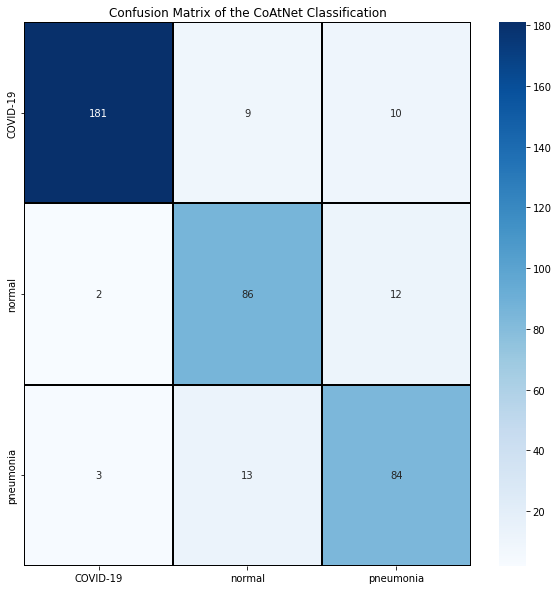

In [89]:
import seaborn as sns
cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
labels = ['COVID-19','normal','pneumonia']
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.title('Confusion Matrix of the CoAtNet Classification')
plt.show()

In [55]:
def plotLearningCurve(accuracy, val_accuracy, loss, val_loss, epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,accuracy,'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,val_accuracy,'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,loss,'b',label = 'Training Loss')
  ax[1].plot(epochRange,val_loss,'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

In [56]:
# recorded acc and loss
accuracy = [0.5723, 0.6815, 0.7372, 0.7577, 0.7776, 0.8044, 0.8065, 0.8138, 0.8287, 0.8321, 0.8274, 0.8367, 0.8508, 0.8431, 0.8665]
val_accuracy = [0.6090, 0.7093, 0.7699, 0.7924, 0.7114, 0.7993, 0.8270, 0.8287, 0.8270, 0.8322, 0.8356, 0.8166, 0.8391, 0.8581, 0.8547]
loss = [0.9380, 0.7623, 0.6340, 0.5697, 0.5314, 0.4861, 0.4690, 0.4567, 0.4160, 0.4063, 0.3978, 0.4010, 0.3659, 0.3853, 0.3415]
val_loss = [0.8317, 0.6688, 0.5918, 0.4845, 0.4466, 0.4469, 0.4336, 0.3923, 0.3883, 0.3980, 0.3837, 0.3982, 0.3723, 0.3503, 0.3536]

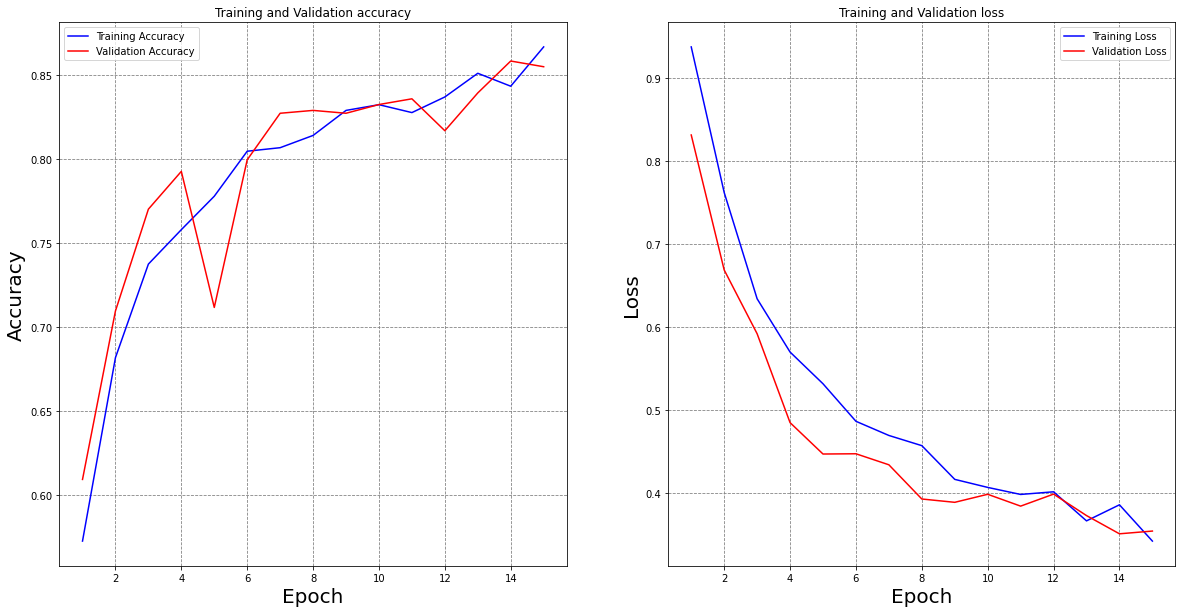

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
plotLearningCurve(accuracy, val_accuracy, loss, val_loss,15)